In [18]:
#%% Imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

# Import "local" packages
import hyspec_io, hyspec_ml, image_render, preprocess 

In [2]:
#%% Paths
tmp_save_dir = Path('/media/mha114/Massimal2/Massimal/X_TemporaryDeletableFiles/PrelimSkalmenDeglint')
# im_paths = ['/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_31-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_32-Crop Wavelengths.bip.hdr', # første eksempel
#             '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_79-Crop Wavelengths.bip.hdr', # dyp sand midt i bildet
#             '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_81-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_24-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_30-Crop Wavelengths.bip.hdr', # godt eksempel
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_42-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_20-Crop Wavelengths.bip.hdr', # godt eksempel
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_25-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_32-Crop Wavelengths.bip.hdr'] # godt eksempel

im_paths = ['/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_24-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_30-Crop Wavelengths.bip.hdr', # godt eksempel
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_42-Crop Wavelengths.bip.hdr'] 
im_paths = [Path(p) for p in im_paths]
sgc_train_im_paths = im_paths 


In [3]:
def train_image_pca(image_paths,n_components=8,random_sample_frac=0.05, normalize=True, verbose=False):
    """ Train PCA model based on randomly sampled spectra from multiple hyperspectral images 
    
    # Input arguments:
    image_paths:
        List of paths to images to include in the dataset for 
        fitting the PCA model.
    
    # Keyword arguments:
    n_components:
        Number of PCA components to include. If None, all components are kept.
    random_sample_frac:
        Indicates the fraction of pixels in the image that will be included
        in the training data for the PCA model. Example:
        random_sample_frac=0.05 indicates that 5% of pixels are extracted.
    normalize:
        Boolean indicating if data should be normalized before fitting the 
        PCA model. If True, spectra are normalized per-wavelength by
        subtracting the mean and dividing by the standard deviation ("z-score").
    verbose:
        Boolean indicating if status updates will be printed during processing.

    # Returns:
    W_pca:
        PCA "components", principal axes representing directions of maximal variance
        in feature space. Shape (n_components, n_features)
    X_mean:
        Per-wavelength mean of data. Shape(n_features,)
    X_scale:
        Per-wavelength scaling of data. Shape (n_features,).
        Corresponds to per-wavelength standard deviation. 
        Only returned if normalize = True .
    
    # Notes:
    The PCA model is fitted using sklearn.decomposition.PCA. The data is always "centered", 
    i.e. the mean value is subtracted. When applying the PCA model to new data, the same
    centering operation should be done, using X_mean (not the mean value of the new data).
    If normalize = True, new data should also be scaled by dividing per-wavelength
    by X_scale.
    """
    # Status update
    if verbose: print(f'Collecting {random_sample_frac*100} % of pixels from {len(image_paths)} images for PCA model')

    # Collect data
    X = []
    for i,image_path in enumerate(image_paths):
        if verbose: print(f'Opening image {i+1} of {len(image_paths)}')
        (im,_,_,_) = hyspec_io.load_envi_image(image_path)
        X.append(hyspec_ml.random_sample_image(im,frac=random_sample_frac))
    X = np.concatenate(X)
    if verbose: print(f'Collected data matrix has shape {X.shape}')

    # Normalize data (optional)
    if normalize:
        if verbose: print('Normalizing data...')
        scaler = StandardScaler(with_mean=False)
        X = scaler.fit_transform(X)
        X_scale = scaler.scale_
    
    # Fit PCA model
    if verbose: print('Fitting PCA model...')
    pca = PCA(n_components=n_components)
    pca.fit(X)
    if verbose: print('Done.')

    # Return
    if normalize:
        return (pca.components_, pca.mean_,X_scale)
    else:
        return (pca.components_, pca.mean_)
    


In [4]:
# W_pca, X_mean, X_scale = train_image_pca(image_paths=sgc_train_im_paths,verbose=True)
W_pca, X_mean = train_image_pca(image_paths=sgc_train_im_paths,verbose=True,normalize=False)

Opening image 1 of 3
Opening image 2 of 3
Opening image 3 of 3
Collected data matrix has shape (269998, 255)
Fitting PCA model...
Done.


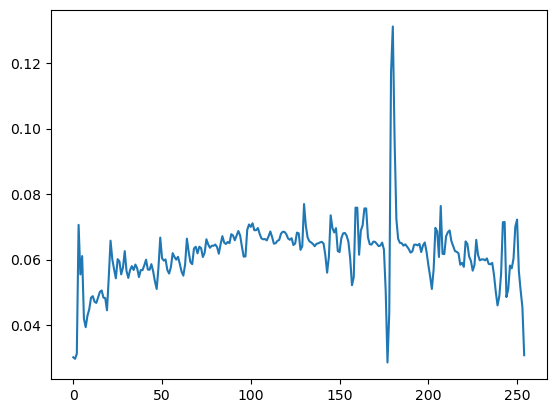

In [5]:
plt.plot(W_pca[0])

In [6]:
image_path = im_paths[-2] 
print(image_path)

/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_30-Crop Wavelengths.bip.hdr


In [7]:
(image,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(image_path)

In [8]:
def remove_sun_glint_pca(image,W_pca,X_mean):
    """ Remove sun glint by subtracting data corresponding to first principal component 
    
    # Input parameters:
    image:
        Hyperspectral image, shape (n_rows, n_columns, n_wavelengths)
    W_pca:
        PCA components (princical axes of highest variance) 
        Shape (n_components, n_wavelenghts)
        Note that only the first principal component is used.
    X_mean:
        Per-wavelength mean value of data used to fit PCA model.
        Shape (n_wavelengths,)
    """
    image_vectorizer = hyspec_ml.ImageVectorizer(nRows=image.shape[0],nCols=image.shape[1])
    zero_mask = ~np.all(image==0,axis=2,keepdims=True)

    # Subtract mean and project onto first component axis
    image_2d = image_vectorizer.image3d_to_matrix(image)
    image_2d_pc1 = (image_2d - X_mean.reshape(1,-1)) @ W_pca[0:1,:].T  # Vector with PC1 values

    # Multiply PC1 value with first component "spectrum" to get glint image
    image_2d_glint = image_2d_pc1 * W_pca[0:1,:]

    # Subtract glint image. Keep input zero pixels equal to zero in output
    image_noglint = image - image_vectorizer.matrix_to_image3d(image_2d_glint)
    return image_noglint * zero_mask

In [9]:
image_noglint = remove_sun_glint_pca(image,W_pca,X_mean)

In [10]:
print(image_noglint.shape)

(2000, 900, 255)


In [11]:
# str(W_pca[0]).replace('\n','')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


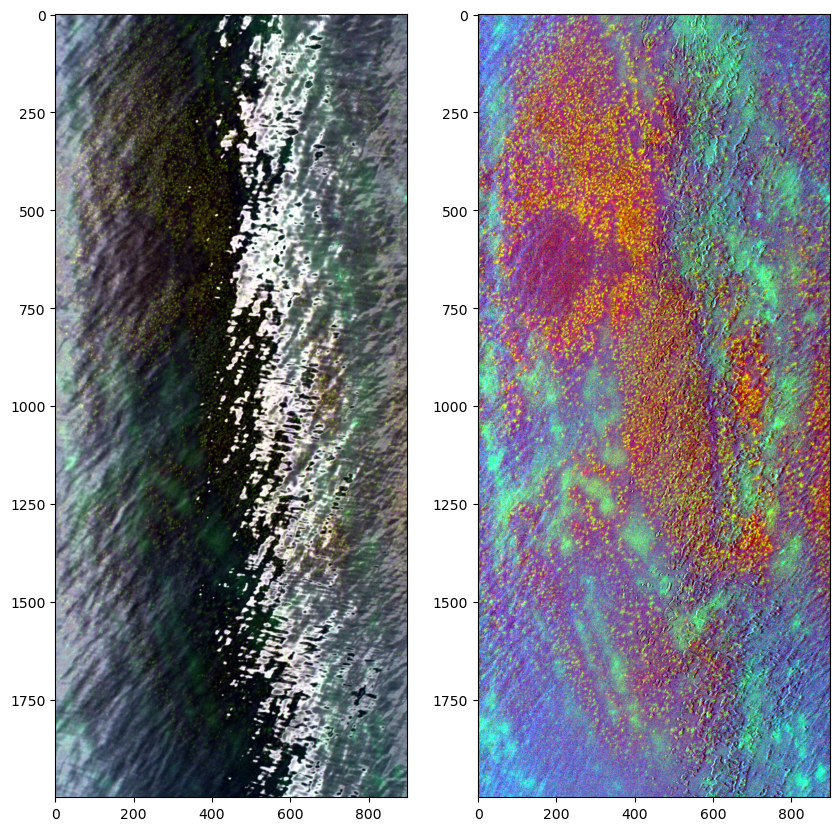

In [12]:
fig,ax = plt.subplots(ncols=2,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(image[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(image_noglint[:,:,rgb_ind]))
plt.show()

In [13]:
def save_pca_scg_image_envi(image_noglint,metadata_original,save_dir,file_name_base,header_file_ext='hdr'):
    """ Save sun glint corrected file in ENVI format 
    
    # Input parameters:
    image_noglint
        Image with glint removed. Shape (n_rows, n_columns, n_wavelengths)
    metadata_original:
        Metadata from original image (see spectral.io.envi.open / hyspec_io.load_envi_image)
    save_dir:
        Directory to save file in (pathlib.Path or string)
    file_name_base
        First part of file name.
    file_header_ext
        Filename extension for header file. Default is '.hdr'
        Binary file is saved with name equal to everything before '.hdr'
        If you want the binary file to be saved as e.g. "image.bip", specify 
        file_header_ext as 'bip.hdr'.

    # Notes:
    - "History" in metadata is updated with sun glint correction information.
    All other metadata is used without modification when saving the file.
    - The string '-PCASGC' is appended to the file name base to create
    the full file name. This is an acronyn for "Principal Component Analysis 
    Sun Glint Correction".
    """

    # Update metadata
    metadata = metadata_original.copy()
    metadata['history'] += ' -> SunGlintCorrectPCA'

    header_file_name = file_name_base + '-PCASGC.' + header_file_ext
    header_file_path = str(Path(save_dir) / header_file_name)

    hyspec_io.save_envi_image(header_file_path,image_noglint,metadata)


In [16]:
# Save image
file_base, file_ext = image_path.name.split('.',maxsplit=1)
save_pca_scg_image_envi(image_noglint,metadata,tmp_save_dir,file_base,header_file_ext=file_ext)

In [19]:
def filter_image_savitzky_golay(image,window_length=13,polyorder=3,axis=2):
    return savgol_filter(image,window_length=window_length,polyorder=polyorder,axis=axis)

In [22]:
image_filtered = filter_image_savitzky_golay(image_noglint)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


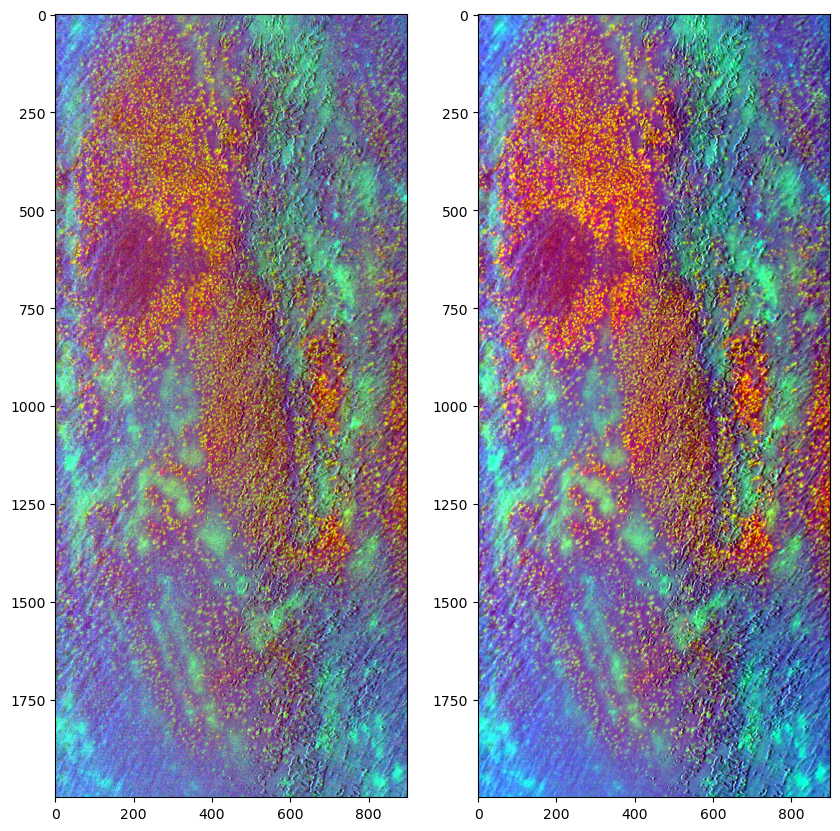

In [23]:
fig,ax = plt.subplots(ncols=2,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(image_noglint[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(image_filtered[:,:,rgb_ind]))
plt.show()